Normalizing flow using nflows package and toy data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import scipy.stats
from scipy.stats import rel_breitwigner
import torch
import sklearn
import os
#instead of manually defining bijectors and distributions, 
#import necessary components from nflows
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nflows.distributions.normal import StandardNormal
from nflows import distributions, flows, transforms
import nflows.transforms as transforms
from nflows.flows import Flow
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
n_epochs=1001
learning_rate=5e-6
batch_size=512 #number of data samples processed before updating the model's parameters
hidden_features=50
num_blocks=6
num_bins=10
num_layers=4
outdir='/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Normalizing_Flows/EstimationNF_outputs'

Setup: 
- bkg: exponential falling distribution
- signal: Breit-Wigner at certain mass 

In [3]:
# Generate background and signal data
n_bkg = 800000
n_sig = 40
bkg = np.random.exponential(scale=100.0, size=n_bkg)
sig = rel_breitwigner.rvs(450, size=n_sig)
# Adding b-tagging information (a form of event classification)
bkg_btag = np.random.uniform(low=0.0, high=1.0, size=n_bkg)
sig_btag = np.random.normal(0.85, 0.05, n_sig)
num_features=2 #dimensionality of the data being transformed.
# In this case: b-tagging score and background energy

Note: the bkg distribution is the posterior/target distribution which the Normalizing Flow should learn to approximate.

In [4]:
#Combining energy and b-tagging score for both bkg and signal 
bkg_coord = np.column_stack((bkg_btag, bkg))  # Combine btag and bkg for training
#Initialize the scaler 
scaler = StandardScaler()
#Scale the target distribution to help the model to converge faster 
bkg_coord_scaled = scaler.fit_transform(bkg_coord)

# Shift the entire dataset to make sure all values are positive
shift = -bkg_coord_scaled[:, 1].min() + 1e-6  # Get the absolute value of the minimum across all features

bkg_coord_scaled[:, 1] += shift  # Add the shift to the entire dataset

bkg_coord_scaled = bkg_coord_scaled.astype('float32') #bkg coordinates converted to float32 for compatibility with python 

# Define base distribution
base_distribution = distributions.StandardNormal(shape=(num_features,))

# Sample points from the base distribution
prior = base_distribution.sample(10000).numpy()  # Sample 10000 points with 2 features each


# Shift the prior distribution to ensure all values are positive
shift_prior = -prior[:, 1].min() + 1e-6  # Add a small constant to avoid zero values
prior[:, 1] += shift_prior  # Apply the shift to the energy feature

Scaled Target - Min: 5.074938e-05
Target - Min: 0.005620338956208801
Prior - Min (energy): 9.536743e-07


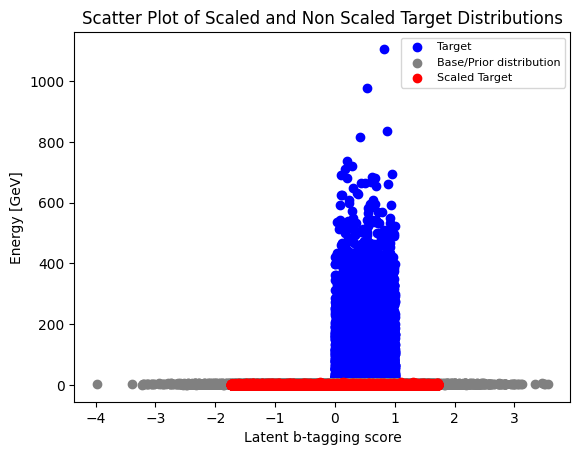

In [5]:
plt.scatter(bkg_coord[:10000, 0], bkg_coord[:10000, 1], color='blue', label='Target')
plt.scatter(prior[:, 0], prior[:, 1], color='gray', label='Base/Prior distribution')
plt.scatter(bkg_coord_scaled[:10000, 0], bkg_coord_scaled[:10000, 1], color='red', label='Scaled Target')
plt.xlabel("Latent b-tagging score")
plt.ylabel("Energy [GeV]")
plt.title("Scatter Plot of Scaled and Non Scaled Target Distributions")
plt.legend(loc='best', fontsize=8)

print("Scaled Target - Min:", bkg_coord_scaled[:10000,1].min())
print("Target - Min:", bkg_coord[:10000,1].min())
print("Prior - Min (energy):", prior[:, 1].min())  # Check min for energy feature

Normalizing flow model:
Set up simple normalizing flow with arbitrary inputs and outputs just to test 

Define transformations (bijectors)
transformations = transforms.MaskedAffineAutoregressiveTransform(features, args.hidden_features, args.num_blocks)

In [6]:
num_context=0
def make_flow(num_features,num_context, perm=True):
    base_dist = distributions.StandardNormal(shape=(num_features,))
    #base_dist = MultivariateScaledNormal(num_features, scale=3.0)
    hidden_features=50
    num_blocks=3
    num_bins=10
    num_layers=3
    transforms = []
    if num_context == 0:
        num_context = None
    for i in range(num_layers):
        transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=num_features,
                                                                                context_features=num_context,
                                                                                hidden_features=hidden_features,
                                                                                num_bins=num_bins,
                                                                                num_blocks=num_blocks,
                                                                                tail_bound=10.0, #range over which the spline trasnformation is defined 
                                                                                tails='linear',
                                                                                dropout_probability=0.2,
                                                                                use_batch_norm=False))
        if i < num_layers - 1 and perm:
            transforms.append(ReversePermutation(features=num_features)) #Shuffles feature order to increase expressivity
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

The higher the number of hidden_features/num_blocks, the more expressive the transformation will be, 
allowing it to capture more complex relationships in the data.
The neural network basically has the base distribution values as inputs and gets to the parameters of the target distribution (via the network). 
Then those parameters are inserted in the target distribution to get the ouputs in correspondence to the inputs. In this case, the neural network has 16 layers. 
Using a neural network inside the transformations in normalizing flows does make the training loop "deeper" 
in the sense that you're not just applying a single transformation but a series of transformations that are learned through the neural network.

Setting up the normalizing flow and the training loop

In [7]:
#Sample points from target distribution for training 
y = torch.from_numpy(bkg_coord_scaled[:100000])  # Take the first 100,000 samples
# Split the data into training and validation sets (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(y))  # 80% for training
train_data = y[:train_size]
val_data = y[train_size:]
#Create and initialize the flow
#flow = Flow(transformations, base_distribution) #encapsules the entire flow model in a more structured way
flow = make_flow(num_features, num_context, perm=True)
#Training loop
opt = torch.optim.Adam(flow.parameters(), learning_rate)
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
#create loaders 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# Define scheduler
scheduler = CosineAnnealingLR(optimizer=opt, T_max=n_epochs, eta_min=1e-3)  # eta_min: minimum LR, T_max: total number of epochs for one cosine cycle 
train_losses=[]
val_losses=[]
min_loss=np.inf # Initialize minimum validation loss
min_loss_epoch=-1
patience_counter=0 # Initialize patience counter

In [8]:
for idx in range(n_epochs):
    flow.train() #set to taining mode 
    total_train_loss=0.0
    
    #loop over training 
    for batch in train_loader:
        batch_data = batch[0]
        opt.zero_grad() #zero the gradients and make predictions for a set of inputs 
        
        # Minimize KL(p || q), i.e. calculate the loss
        train_loss = -flow.log_prob(batch_data).mean() #calculating the log probability for batch
        train_loss.backward() 
        opt.step() #model updates its parameters (weights) 
        total_train_loss += train_loss.item() * batch_data.size(0) #accumulate batch loss 

    #Calculate average training loss for the current epoch
    avg_train_loss = total_train_loss / len(train_data)
    # Append the loss for plotting later
    train_losses.append(avg_train_loss)
    
    #Validation loss (analogously to training loss)
    flow.eval() #set to evaluation mode 
    total_val_loss=0.0
    
    #loop over validation 
    with torch.no_grad():
        for val_batch in val_loader:
            val_batch_data = val_batch[0]
            
            # Minimize KL(p || q)
            val_loss = -flow.log_prob(val_batch_data).mean() #calculating the log probability for validation
            total_val_loss += val_loss.item() * val_batch_data.size(0) #accumulate batch loss 
    
    #Calculate average validation loss for the current epoch
    avg_val_loss = total_val_loss / len(val_data) 
    # Append the loss for plotting later
    val_losses.append(avg_val_loss)
    
    # Scheduler step for CosineAnnealingLR
    scheduler.step() #adjusts the learning rate at each epoch based on cosine formula 

    # Early stopping based on patience mechanism 
    # Patience mechanism keeps track of how many epochs have passed without improvement in loss. 
    # If the loss does not improve for 5 consecutive epochs, the training stops early to prevent overfitting.

    if avg_val_loss < min_loss: #compare the epoch-level validation loss to min_loss
        min_loss = avg_val_loss
        min_loss_epoch = idx # Track the epoch where minimum loss occurs
        patience_counter = 0 # Reset patience counter if the loss improves

        '''
        model_path = os.path.join(outdir, "best_model.pth")
        torch.save(flow.state_dict(), model_path)  
        '''
    else:
        patience_counter += 1
        if patience_counter >= 10: # If no improvement for 5 epochs, stop training
            print("Early stopping triggered")
            break
    
    # Use val_loss for early stopping because it provides a measure of how well the model generalizes to unseen data.
    # By monitoring val_loss instead of train_loss, we ensure that training does not continue if the model starts to overfit.
    # Early stopping based on val_loss helps prevent the model from improving solely on training data performance, which could lead to overfitting.   

    # Print progress every epoch
    if idx % 1 == 0:
        print(f"Epoch {idx}, Avg Train Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

Epoch 0, Avg Train Loss: 5.0127, Avg Validation Loss: 4.3681
Epoch 1, Avg Train Loss: 3.9210, Avg Validation Loss: 3.5476
Epoch 2, Avg Train Loss: 3.3732, Avg Validation Loss: 3.2296
Epoch 3, Avg Train Loss: 3.1465, Avg Validation Loss: 3.0514
Epoch 4, Avg Train Loss: 2.9981, Avg Validation Loss: 2.9225
Epoch 5, Avg Train Loss: 2.8861, Avg Validation Loss: 2.8290
Epoch 6, Avg Train Loss: 2.8071, Avg Validation Loss: 2.7646
Epoch 7, Avg Train Loss: 2.7503, Avg Validation Loss: 2.7184
Epoch 8, Avg Train Loss: 2.7080, Avg Validation Loss: 2.6797
Epoch 9, Avg Train Loss: 2.6702, Avg Validation Loss: 2.6439
Epoch 10, Avg Train Loss: 2.6350, Avg Validation Loss: 2.6075
Epoch 11, Avg Train Loss: 2.5974, Avg Validation Loss: 2.5687
Epoch 12, Avg Train Loss: 2.5568, Avg Validation Loss: 2.5255
Epoch 13, Avg Train Loss: 2.5143, Avg Validation Loss: 2.4810
Epoch 14, Avg Train Loss: 2.4769, Avg Validation Loss: 2.4471
Epoch 15, Avg Train Loss: 2.4512, Avg Validation Loss: 2.4250
Epoch 16, Avg Trai

In [9]:
'''
# Load the best model after training
model_path = os.path.join(outdir, "best_model.pth")
flow.load_state_dict(torch.load(model_path, weights_only=True))
flow.eval()  # Set the model to evaluation mode
print("Best model loaded successfully.")
'''

# Sample points from the trained flow
trained = flow.sample(10000).detach().numpy()  # Sample 10000 points with 2 features each
print("Trained - Min (energy):", trained[:, 1].min())

Trained - Min (energy): -0.12961465


In [10]:
# Function to calculate KL divergence between target and trained distribution
def calculate_kl_divergence(target, trained, eps=1e-8):
    # Ensure target and trained are in probability space and avoid log(0) errors
    target = np.clip(target, eps, 1)  # Clip target values to avoid zero probabilities
    trained = np.clip(trained, eps, 1)  # Same for trained values
    # This prevents taking the logarithm of zero, which would lead to undefined (NaN) values and numerical instability in the KL divergence calculation. 
    # By clipping to this small positive value, it ensures no probability is exactly zero.
    # Normalize to make them proper probability distributions
    target /= np.sum(target)
    trained /= np.sum(trained)
    # Convert numpy arrays to PyTorch tensors
    p_target = torch.from_numpy(target).float()
    q_trained = torch.from_numpy(trained).float().log()  # q_trained should be in log space

    # Calculate KL divergence
    kl_divergence = torch.nn.functional.kl_div(q_trained, p_target, reduction='batchmean')
    return kl_divergence.item()
# Calculate KL divergence
kl_div = calculate_kl_divergence(bkg_coord_scaled[:10000], trained)

'''
# Save KL divergence value
kl_div_path = os.path.join(outdir, "kl_divergence.npy")
np.save(kl_div_path, kl_div)
print("KL divergence saved successfully.")
'''


'\n# Save KL divergence value\nkl_div_path = os.path.join(outdir, "kl_divergence.npy")\nnp.save(kl_div_path, kl_div)\nprint("KL divergence saved successfully.")\n'

Text(0.05, 0.95, 'learning_rate: 5e-06\nnum_layers: 4\nnum_blocks: 6\nhidden_features: 50\nnum_bins: 10\nn_epochs: 1001\nKL Divergence: 0.0004')

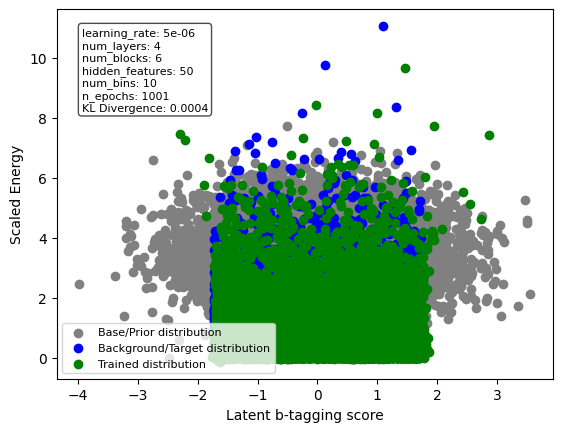

In [14]:
# After creating the scatter plot
plt.scatter(prior[:, 0], prior[:, 1], color='gray', label='Base/Prior distribution')
plt.scatter(bkg_coord_scaled[:10000, 0], bkg_coord_scaled[:10000, 1], color='blue', label='Background/Target distribution')
plt.scatter(trained[:, 0], trained[:, 1], color='green', label='Trained distribution')
plt.xlabel("Latent b-tagging score")
plt.ylabel("Scaled Energy")
plt.legend(loc='lower left', fontsize=8)

# Display hidden_features, num_blocks, and KL divergence in the plot
text_str = f"learning_rate: {learning_rate}\nnum_layers: {num_layers}\nnum_blocks: {num_blocks}\nhidden_features: {hidden_features}\nnum_bins: {num_bins}\nn_epochs: {n_epochs}\nKL Divergence: {kl_div:.4f}"
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7))

Plot training and validation loss per epoch
Training loss: measures how well your model is fitting the target distribution
Validation loss: measures how well your model generalizes to unseen data fro the same target disribution

Text(0.6, 0.95, 'learning_rate: 5e-06\nnum_layers: 4\nnum_blocks: 6\nhidden_features: 50\nnum_bins: 10\nn_epochs: 1001\nKL Divergence: 0.0004\nMin Loss: 2.2680 at Epoch 133')

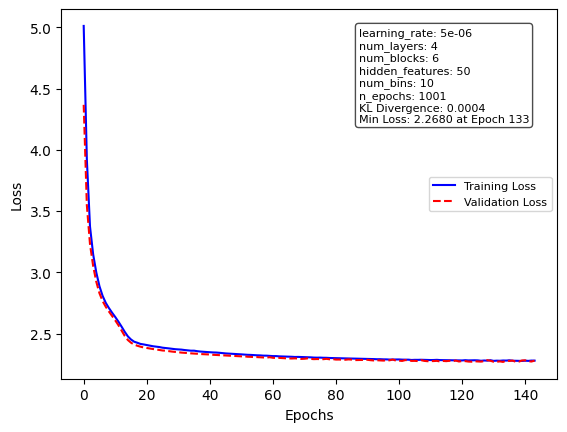

In [15]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color='blue') #training loss 
plt.plot(val_losses, label="Validation Loss", color='red', linestyle='--') #validation loss 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=8)
# Display the minimum loss and the corresponding epoch in the plot
text_str = f"learning_rate: {learning_rate}\nnum_layers: {num_layers}\nnum_blocks: {num_blocks}\nhidden_features: {hidden_features}\nnum_bins: {num_bins}\nn_epochs: {n_epochs}\nKL Divergence: {kl_div:.4f}\nMin Loss: {min_loss:.4f} at Epoch {min_loss_epoch}"
plt.text(0.6, 0.95, text_str, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7))

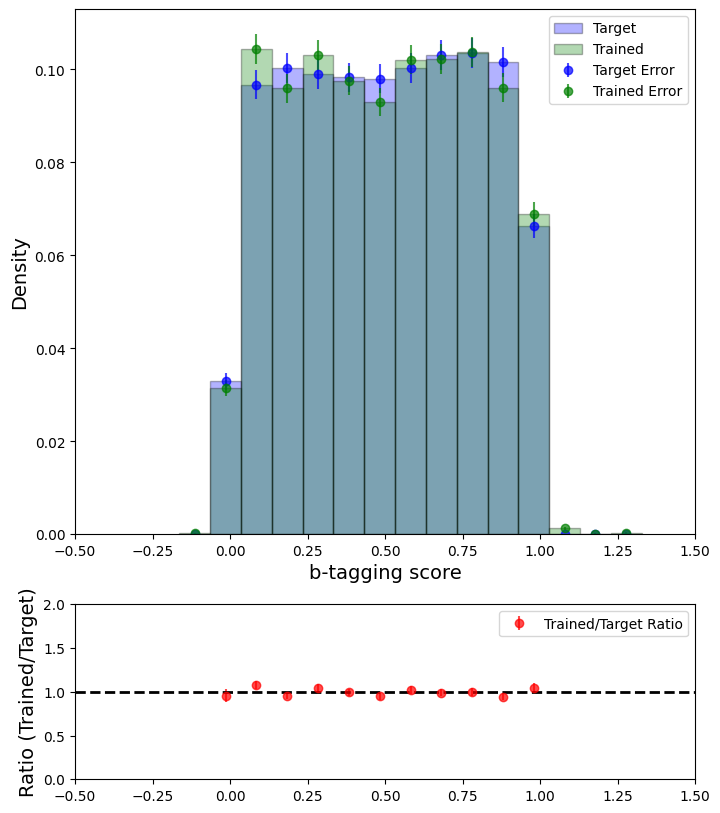

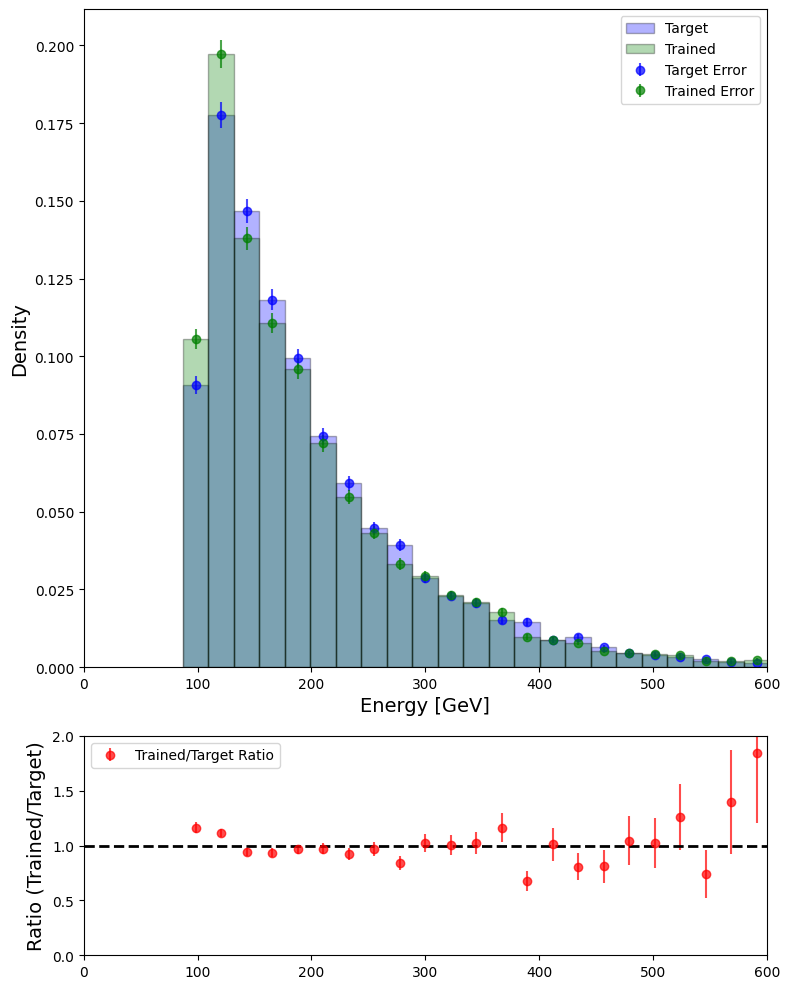

In [18]:
# Function to plot marginal distributions
def plot_marginals(target, trained, feature_names, scaler):
    num_features = target.shape[1]
    
    # Inverse transform to get original features
    target_original = scaler.inverse_transform(target)
    trained_original = scaler.inverse_transform(trained)
    
    for i in range(num_features):
        fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        target_feature = target_original[:, i]
        trained_feature = trained_original[:, i]
        feature_label = feature_names[i]
        
        if i == 1:  # Assuming energy is the second feature (index 1)
            # Set x-axis limits for energy feature
            x_limits = (0, 600)
            bins=50
        else:
            # Set x-axis limits for non-energy features (e.g., b-tagging score)
            x_limits = (-0.5, 1.5)
            bins=15
        
        # Combine data for consistent binning
        all_data = np.concatenate([target_feature, trained_feature])
        bin_edges = np.linspace(np.min(all_data), np.max(all_data), bins + 1)
            
        # Recalculate the histograms using the same bin edges
        hist_target_counts, _ = np.histogram(target_feature, bins=bin_edges)
        hist_trained_counts, _ = np.histogram(trained_feature, bins=bin_edges)
        
        # Total counts for normalization
        N_target_total = np.sum(hist_target_counts)
        N_trained_total = np.sum(hist_trained_counts)
        
        # Normalize histograms (including empty bins)
        hist_target = hist_target_counts / N_target_total
        hist_trained = hist_trained_counts / N_trained_total
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Error estimation for histograms
        err_target = np.sqrt(hist_target_counts) / N_target_total
        err_trained = np.sqrt(hist_trained_counts) / N_trained_total
        
        # Main plot (marginal histograms)
        ax_main.bar(bin_centers, hist_target, width=np.diff(bin_edges), alpha=0.3, label='Target', color='blue', edgecolor='black', align='center')
        ax_main.bar(bin_centers, hist_trained, width=np.diff(bin_edges), alpha=0.3, label='Trained', color='green', edgecolor='black', align='center')
        ax_main.errorbar(bin_centers, hist_target, yerr=err_target, fmt='o', color='blue', label='Target Error', alpha=0.7)
        ax_main.errorbar(bin_centers, hist_trained, yerr=err_trained, fmt='o', color='green', label='Trained Error', alpha=0.7)
        ax_main.set_xlabel(feature_label, fontsize=14)
        ax_main.set_ylabel("Density", fontsize=14)
        ax_main.legend(fontsize=10)
        if x_limits:
            ax_main.set_xlim(x_limits)
            
        # Calculate bin-by-bin ratio of normalized counts (target/trained)
        
        # ------------------- FILTERING PART -------------------
        
        # Filter bins where both histograms have sufficiently large counts
        valid_bins = (hist_target_counts > 1e-3) & (hist_trained_counts > 1e-3)  # Avoid empty/low-count bins
        
        # Filter histograms and bins for valid data only
        bin_centers_filtered = bin_centers[valid_bins]
        target_hist_filtered = hist_target[valid_bins]
        trained_hist_filtered = hist_trained[valid_bins]
        
        # ------------------- Ratio Calculation -------------------
        
        # Calculate ratio and its error
        ratio = trained_hist_filtered / target_hist_filtered
        
        # Calculate errors (Poisson errors)
        err_ratio = ratio * np.sqrt((err_target[valid_bins] / target_hist_filtered) ** 2 +(err_trained[valid_bins] / trained_hist_filtered) ** 2)
    
        # Ratio plot (target/trained ratio)
        ax_ratio.errorbar(bin_centers_filtered, ratio, yerr=err_ratio, fmt='o', label='Trained/Target Ratio', color='red', alpha=0.7)
        ax_ratio.set_ylabel("Ratio (Trained/Target)", fontsize=14)
        ax_ratio.legend(fontsize=10)
        ax_ratio.set_xlim(x_limits)  # Apply feature-specific x-axis limits
        ax_ratio.set_ylim(0.0, 2.0)  # Zoom in on the ratio plot
        ax_ratio.axhline(y=1, color='black', linestyle='--', linewidth=2)  # Horizontal line at y=1
        
    plt.tight_layout()
    plt.show()
        
# Call the function with the necessary arguments
feature_names = ["b-tagging score", "Energy [GeV]"]
plot_marginals(bkg_coord_scaled[:10000], trained, feature_names, scaler)